In [263]:
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image
from pathlib2 import Path
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import skimage.transform

In [9]:
original_image_dir = Path('original_images/')
modified_image_dir = Path('modified_images/')

original_image_paths = list(original_image_dir.glob('*.png'))
modified_image_paths = list(modified_image_dir.glob('*.png'))

print 'original {}, modified {}'.format(len(original_image_paths), 
                                        len(modified_image_paths))

original 1788, modified 1788


In [16]:
blah = cv2.imread(str(rotated_image_name))
blah.shape

(357, 500, 3)

In [22]:
# image statistics
def image_info(filepath):
    image = cv2.imread(str(filepath))
    height, width, channels = image.shape
    
    return {'filename':str(filepath), 
            'height': height, 
            'width': width,
            'channels': channels}


original_dimensions = pd.DataFrame([image_info(f) for f in original_image_paths])
modified_dimensions = pd.DataFrame([image_info(f) for f in modified_image_paths])

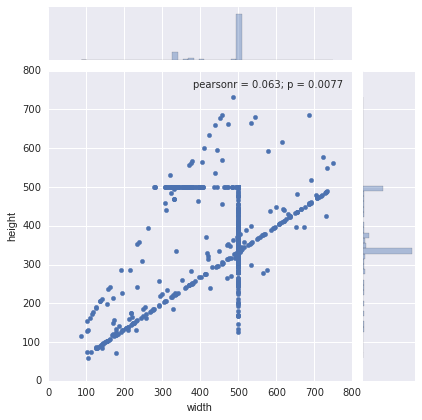

In [28]:
sns.jointplot(data=modified_dimensions, x='width', y='height')

In [40]:
# before we get into this, let's try a perceptual hash
import imagehash

original_hashes_a = {imagehash.average_hash(Image.open(str(f))): f for f in original_image_paths}
modified_hashes_a = {imagehash.average_hash(Image.open(str(f))): f for f in modified_image_paths}

original_hashes_p = {imagehash.phash(Image.open(str(f))): f for f in original_image_paths}
modified_hashes_p = {imagehash.phash(Image.open(str(f))): f for f in modified_image_paths}

original_hashes_d = {imagehash.dhash(Image.open(str(f))): f for f in original_image_paths}
modified_hashes_d = {imagehash.dhash(Image.open(str(f))): f for f in modified_image_paths}

original_hashes_w = {imagehash.whash(Image.open(str(f))): f for f in original_image_paths}
modified_hashes_w = {imagehash.whash(Image.open(str(f))): f for f in modified_image_paths}

In [43]:
# iterate through ohashes, trying to match
def match(ohash, mhash):
    unpaired = []
    for h, f in ohash.iteritems():
        if h not in mhash.keys():
            unpaired.append(f)

    print(len(unpaired))
    

print 'a'
match(original_hashes_a, modified_hashes_a)
print 'p'
match(original_hashes_p, modified_hashes_p)
print 'w'
match(original_hashes_w, modified_hashes_w)
print 'd'
match(original_hashes_d, modified_hashes_d)

a
1201
p
1229
w
1141
d
1275


In [308]:
import csv

def write_results(ohash, mhash):
    with open('results.csv', 'wb') as csvfile:
        
        writer = csv.writer(csvfile, delimiter=',')
        
        for h, f in ohash.iteritems():
            if h in mhash.keys():
#                 pairs.append((f.parts[1], mhash[h].parts[1]))
                writer.writerow((f.parts[1], mhash[h].parts[1]))

            
write_results(original_hashes_w, modified_hashes_w)

Types of transforms

- blur
- rotate
    - all the rotations don't pad the boundary with anything, fit a minimal area rectangle to everything non-black should get them
- color transform (-> gray, -> weird)

preprocessing pipeline
- grayscale (undo color transforms)
- rectify (undo rotations pt 1)
- optionally, rotate right to make landscape
- center crop (by percentage) (undo rotations pt 2)
- blur and downsample to minimal size (32 x 32)

calculate rmse pairwise across dataset

In [ ]:
rotated_image_name = Path('./modified_images/fe6c006d-655b-4f69-b7d8-c8063df3d2d3.png')
gray_image_name = Path('./modified_images/fe984cbe-8906-46eb-b4d2-c6000836fbb2.png')

image_1 = Path('./modified_images/90ff1040-9b89-4d38-882b-09466867266f.png')
image_2 = Path('./original_images/')

In [303]:
rotated_image_name = Path('./modified_images/fe6c006d-655b-4f69-b7d8-c8063df3d2d3.png')
gray_image_name = Path('./modified_images/fe984cbe-8906-46eb-b4d2-c6000836fbb2.png')

modified = Path('./modified_images/90ff1040-9b89-4d38-882b-09466867266f.png')
original = Path('./original_images/26940450475_1e16103e28_h.png')

orb = cv2.ORB()

                          
def orb_features(image, blur=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if blur:
        gray = cv2.GaussianBlur(gray, (11, 11), sigmaX=0)
                          
    kp, des = orb.detectAndCompute(gray, None)
#     kp, des = detectandcompute(gray, None)
    
#     test = cv2.drawKeypoints(gray, kp, color=(0, 255, 0))
    
#     plt.

    return kp, des
    
index_params = {
    'algorithm':6,
    'trees':5
}

search_params = {
    'checks': 50
}


flann = cv2.FlannBasedMatcher(index_params, search_params)




def match_quality(im1_path, im2_path):
    im1 = cv2.imread(str(im1_path))
    im2 = cv2.imread(str(im2_path))

    kp1, des1 = orb_features(im1, blur=True)    
    kp2, des2 = orb_features(im2, blur=True)
    
    if des1 is None or des2 is None:
        return 0
    
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = 0.
    for i, m in enumerate(matches):
        if len(m) < 2:
            good_matches += 1
            continue
        if m[0].distance < 0.7*m[1].distance:
            good_matches += 1


    match_quality = good_matches / len(matches)
    return match_quality




# naively search
path_pairs = []
for i, original_path in enumerate(original_image_paths):
    print '\r{}'.format(i)
    candidate = None
    best_match = 0
    for modified_path in modified_image_paths:
        quality = match_quality(original_path, modified_path)
        if  quality > best_match:
            best_match = quality
            candidate = modified_path
            
    path_pairs.append((original_path.parts[1], candidate.parts[1]))

# draw_params = dict(matchColor = (0,255,0),
#                    singlePointColor = (255,0,0),
#                    matchesMask = matchesMask,
#                    flags = 0)

# img3 = cv2.d(img1,kp1,img2,kp2,matches,None,**draw_params)
# plt.figure()
# plt.imshow(img3,),plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

AttributeError: 'NoneType' object has no attribute 'parts'

In [304]:
import csv
with open('result.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in path_pairs:
        writer.writerow(row)